In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
rt_df = pd.read_csv("data/NSE_CLEAN_RET_NIFTY.csv")
rt_df['Date'] = pd.to_datetime(rt_df['Date'])  # Convert string to datetime
rt_df.set_index('Date', inplace=True) 
# formation period total return including dividends
# form_ret = rt_df.loc["2002-01-01":"2002-12-31"].copy()
# trade_ret = rt_df.loc["2003-01-01":"2003-06-30"]
# rt_df.head()

In [3]:
dates = rt_df.index
total_days = len(dates) #5588
n_formation = 12
n_trading = 6
num_pairs = 5
d_open = 2
wait1d = 1
# storage for results
strat_returns_cc_w1d = pd.DataFrame(np.zeros((total_days, n_trading)), index = dates, columns = ["P_"+str(i+1) for i in range(n_trading)])
strat_returns_fi_w1d = strat_returns_cc_w1d.copy()
num_open_pairs_w1d = pd.DataFrame(np.zeros((total_days, n_trading)), index = dates, columns = ["P_"+str(i+1) for i in range(n_trading)])
# print(strat_returns_cc_w1d)
# print(num_open_pairs_w1d)

month_id = pd.Series(dates.month)
month_id = (month_id.diff()!=0)
month_id.loc[0] = 0  
month_id = month_id.cumsum()

unique_months = month_id.unique()
# print(unique_months)

/var/folders/cm/69k42yy95z5gwss1vrkqcdgm0000gn/T/ipykernel_4227/3296844975.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  month_id.loc[0] = 0


In [4]:
%load_ext autoreload
%autoreload 2 
portfolios = []
from Utils import process_single_pair
from Utils import calculate_pairs_returns
from Utils import get_pairs_area_based
# from sklearn.metrics import pairwise_distances
# import itertools
from Utils import get_pairs_triplet_heron
from Utils import get_pairs
from Utils import main_backtest

import time
all_trade_logs = []   # collect trade logs from every window & portfolio

# for i_port in range(n_trading):
for i_port in range(n_trading):

    port_name = "P_" + str(i_port+1)
    
    print("Running portfolio " + str(i_port+1) + " of ", str(n_trading))
    tic = time.perf_counter()
    
    # Each portfolio pairs can start after (n_formation + i - 1) months 
    # eg. portfolio 1 can start after 12 months if n_formation = 12
    #     portfolio 2 can start after 13 months etc
    
    
    date_rng = np.arange(start=n_formation + i_port, stop=len(unique_months) - n_trading + 1, step=n_trading)
    #print(date_rng)
    for i in date_rng: 
        #tic = time.perf_counter()
        # print("running for i (date_rng) ", i)
        train = np.array(unique_months[i-n_formation:i])
        test = np.array(unique_months[i:i+n_trading])
        form_dates = pd.date_range(dates[month_id == train.min()][0], dates[month_id == train.max()][-1])
        trade_dates = pd.date_range(dates[month_id == test.min()][0], dates[month_id == test.max()][-1])    
        # print("where train and test are ", train, test, form_dates.min(), form_dates.max())
        portfolios.append({
                        'portfolio': port_name,
                        'formation_start': form_dates.min(),
                        'formation_end': form_dates.max(),
                        'trading_start': trade_dates.min(),
                        'trading_end': trade_dates.max(),
                        'formation_days': (form_dates.max() - form_dates.min()).days + 1,
                        'trading_days': (trade_dates.max() - trade_dates.min()).days + 1
                    })
    
        #print("Formation: ", form_dates[0], " to ", form_dates[-1])
        #print("Trading: ", trade_dates[0], " to ", trade_dates[-1])
    
        # check available stocks
    
        # select only stocks:
        #  - with returns for entire formation period
        #  - with volumes > 0 for every day of formation period
    
        form_ret = rt_df[form_dates[0]:form_dates[-1]].copy() #rt_df
    
        # daily volumes for formation period
        # form_vol = vol[form_dates[0]:form_dates[-1]].copy()
        # form_vol = form_vol.fillna(0)
    
        #toc = time.perf_counter()
        #print(f"Slicing data took {(toc - tic):0.4f} seconds")
    
        #tic = time.perf_counter()
        # boolean to identify eligible stocks
        ava_stocks = form_ret.isna().sum() == 0
    
        # formation and trading returns for selected stocks
        form_ret = rt_df.loc[form_dates[0]:form_dates[-1], ava_stocks]
        trade_ret = rt_df.loc[trade_dates[0]:trade_dates[-1], ava_stocks]
    
        # select pairs
        pairs = get_pairs_area_based(form_ret, 5)
        # pairs = get_pairs_triplet_heron(form_ret, 5)
        
        # print(pairs)
        #toc = time.perf_counter()
        #print(f"Selecting pairs took {(toc - tic):0.4f} seconds")
    
        #tic = time.perf_counter()
        # trade pairs
        trades = calculate_pairs_returns(trade_ret, pairs, d_open, wait1d)   
        if "trade_log" in trades and len(trades["trade_log"]) > 0:
            tl = trades["trade_log"].copy()
            tl["portfolio"] = port_name
            tl["form_start"] = form_dates[0]
            tl["form_end"]   = form_dates[-1]
            tl["trade_start"] = trade_dates[0]
            tl["trade_end"]   = trade_dates[-1]
            all_trade_logs.append(tl)

        #toc = time.perf_counter()
        #print(f"Calculating pairs returns took {(toc - tic):0.4f} seconds")
        
        # store results
        strat_returns_cc_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = trades["returns_cc"].values
        strat_returns_fi_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = trades["returns_fi"].values
        num_open_pairs_w1d.loc[trade_dates[0]:trade_dates[-1], port_name] = (trades["directions"]!=0).sum(axis=1).values
    toc = time.perf_counter()
    print(f"Running portfolio took {(toc - tic)/60.:0.2f} minutes")
trade_log_all = pd.concat(all_trade_logs, ignore_index=True) if all_trade_logs else pd.DataFrame()


Running portfolio 1 of  6
Running portfolio took 1.47 minutes
Running portfolio 2 of  6
Running portfolio took 1.38 minutes
Running portfolio 3 of  6
Running portfolio took 1.31 minutes
Running portfolio 4 of  6
Running portfolio took 1.30 minutes
Running portfolio 5 of  6
Running portfolio took 1.31 minutes
Running portfolio 6 of  6
Running portfolio took 1.30 minutes


In [ ]:
# strat_returns_fi_w1d
# num_open_pairs_w1d
# all_trade_logs

In [5]:
daily_port_ret = strat_returns_fi_w1d.mean(axis=1).fillna(0.0)

import numpy as np

def max_drawdown(cum):
    """cum: cumulative curve (e.g., (1+r).cumprod())"""
    roll_max = np.maximum.accumulate(cum.values)
    drawdown = cum.values / roll_max - 1.0
    return float(drawdown.min())

def downside_deviation(r, rf=0.0):
    """r: daily returns in decimal; downside wrt rf/0"""
    neg = np.minimum(r - rf/252.0, 0.0)
    return float(np.sqrt((neg**2).mean()))
def calmar_ratio(r, periods_per_year=252):
    """Calmar Ratio = Annualized Return / |Max Drawdown|"""
    if len(r) == 0:
        return np.nan
    ann_return = (1.0 + r.mean()) ** periods_per_year - 1.0
    cum_curve = (1.0 + r).cumprod()
    mdd = max_drawdown(cum_curve)
    if mdd == 0:
        return np.nan
    return float(ann_return / abs(mdd))



# ---- Portfolio-level metrics ----
r = daily_port_ret.dropna().astype(float)
T = len(r)
cum_curve = (1.0 + r).cumprod()

cum_ret = cum_curve.iloc[-1] - 1.0
ann_ret = (1.0 + r.mean())**252 - 1.0
ann_vol = float(r.std(ddof=0) * np.sqrt(252))
sharpe  = float((r.mean() / r.std(ddof=0)) * np.sqrt(252)) if r.std(ddof=0) > 0 else np.nan
sortino = float((r.mean() * 252) / (downside_deviation(r) * np.sqrt(252))) if downside_deviation(r) > 0 else np.nan
calmar  = calmar_ratio(r)  # <---- NEW LINE

mdd     = max_drawdown(cum_curve)

# Simple parametric 1-day VaR/CVaR at 95% (optional)
mu, sd = float(r.mean()), float(r.std(ddof=0))
var_95 = mu + sd * np.quantile(np.random.normal(size=100000), 0.05)  # or -1.645*sd if centered
# Better (non-parametric):
var_95_np = float(np.quantile(r, 0.05))
cvar_95_np = float(r[r <= var_95_np].mean()) if (r <= var_95_np).any() else np.nan

# Average concurrent open pairs (sanity metric)
avg_open_pairs = float(num_open_pairs_w1d.mean(axis=1).mean())

# ---- Trade-level metrics (from the global trade log) ----
if not trade_log_all.empty:
    total_trades = int(len(trade_log_all))
    avg_dur_days = float(trade_log_all["duration_bars"].mean())  # or "duration_days" if you want calendar days
    win_rate = float((trade_log_all["pnl"] > 0).mean() * 100.0)
    avg_profit_per_trade_pct = float(trade_log_all["pnl"].mean() * 100.0)  # pnl is decimal → %
else:
    total_trades = 0
    avg_dur_days = np.nan
    win_rate = np.nan
    avg_profit_per_trade_pct = np.nan

# ---- Assemble Table 4.2 ----
table_4_2 = pd.DataFrame({
    "Value": [
        total_trades,
        round(avg_dur_days, 2),
        round(win_rate, 2),
        round(avg_profit_per_trade_pct, 4),
        round((cum_ret * 100.0), 2),
        round((ann_ret * 100.0), 2),
        round((ann_vol * 100.0), 2),
        round(sharpe, 2),
        round(sortino, 2),
        round((mdd * 100.0), 2),
        round((calmar), 2),                            # <---- NEW LINE
        round((var_95_np * 100.0), 2),
        round((cvar_95_np * 100.0), 2),
        round(avg_open_pairs, 2),
    ]
}, index=[
    "Total Number of Trades",
    "Average Trade Duration (days)",
    "Win Rate (%)",
    "Average Profit per Trade (%)",
    "Cumulative Return (%)",
    "Annualized Return (%)",
    "Annualized Volatility (%)",
    "Sharpe Ratio",
    "Sortino Ratio",
    "Maximum Drawdown (%)",
    "Calmar Ratio",                                  # <---- NEW LINE
    "VaR (95%) — non-parametric (%)",
    "CVaR (95%) — non-parametric (%)",
    "Avg Concurrent Open Pairs"
])
print(table_4_2)


                                     Value
Total Number of Trades           1627.0000
Average Trade Duration (days)      47.5700
Win Rate (%)                       58.5100
Average Profit per Trade (%)        0.3059
Cumulative Return (%)              10.7300
Annualized Return (%)               1.3300
Annualized Volatility (%)          13.1300
Sharpe Ratio                        0.1000
Sortino Ratio                       0.1400
Maximum Drawdown (%)              -36.6200
Calmar Ratio                        0.0400
VaR (95%) — non-parametric (%)     -1.2500
CVaR (95%) — non-parametric (%)    -1.9000
Avg Concurrent Open Pairs           2.3400


/var/folders/cm/69k42yy95z5gwss1vrkqcdgm0000gn/T/ipykernel_4227/2550558566.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret_monthly = ret_daily.resample('M').agg(lambda x: (x + 1).prod() - 1)


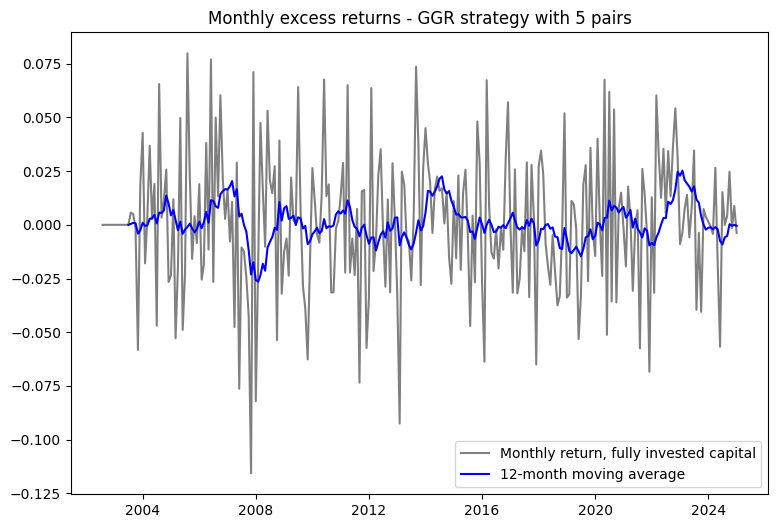

In [11]:
ret_cc_w1d = strat_returns_cc_w1d.mean(axis = 1)
ret_fi_w1d = strat_returns_fi_w1d.mean(axis = 1)

# dataframe with daily returns of commited capital (cc) and fully invested (fi)
ret_daily = pd.DataFrame({"ret_cc": ret_cc_w1d, "ret_fi": ret_fi_w1d})

# calculate monthly returns - used resample at monthly frequency and lambda function to compound
ret_monthly = ret_daily.resample('M').agg(lambda x: (x + 1).prod() - 1)

# calculate 12-month moving average
ret_12_month = ret_monthly.rolling(12).mean()
ret_12_month

fig = plt.figure();
fig.set_size_inches(9, 6);
ax = fig.add_subplot();
ax.plot(ret_monthly["ret_fi"], color = "gray", label = "Monthly return, fully invested capital" );
ax.plot(ret_12_month["ret_fi"], color = "blue", label = "12-month moving average");
ax.set_title("Monthly excess returns - GGR strategy with 5 pairs")
ax.legend();
plt.savefig("img/MER_triplet.jpg")


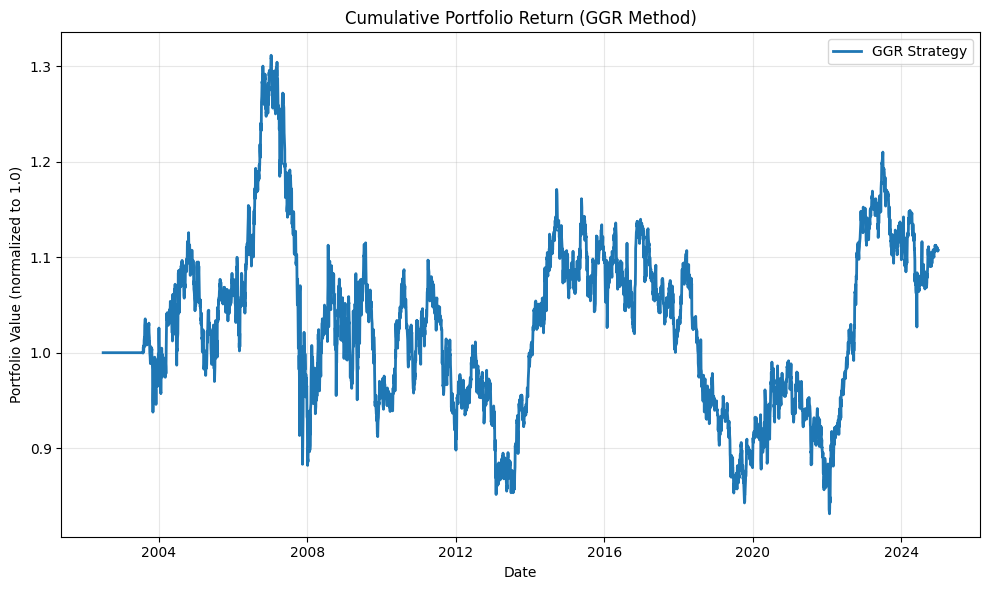

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(cum_curve, linewidth=2, label="GGR Strategy")
plt.title("Cumulative Portfolio Return (GGR Method)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (normalized to 1.0)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("img/Portfolio_triplet.jpg")

plt.show()



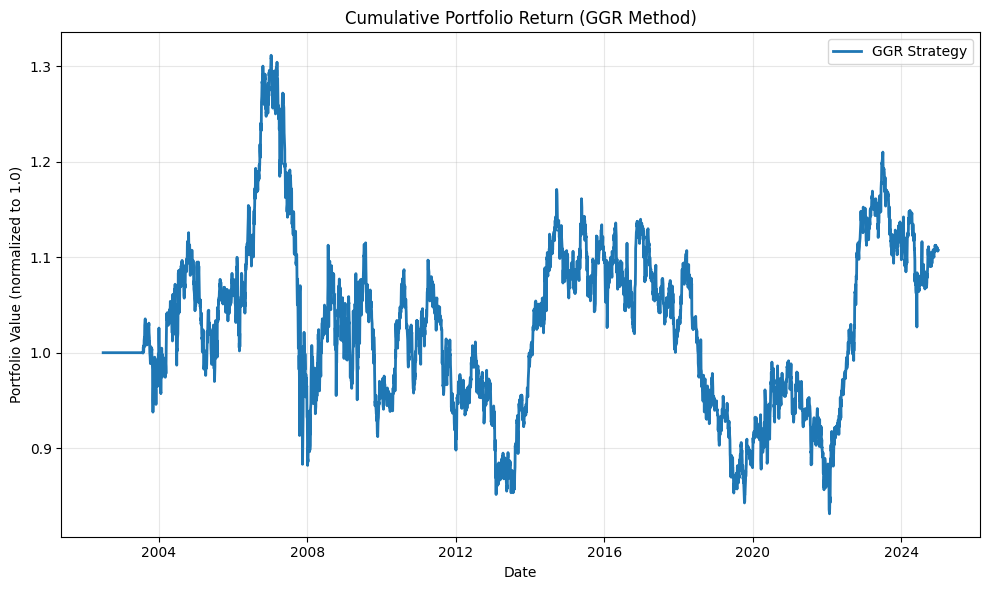

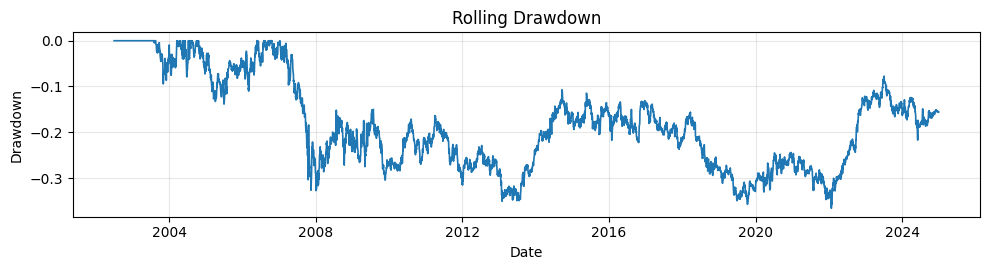

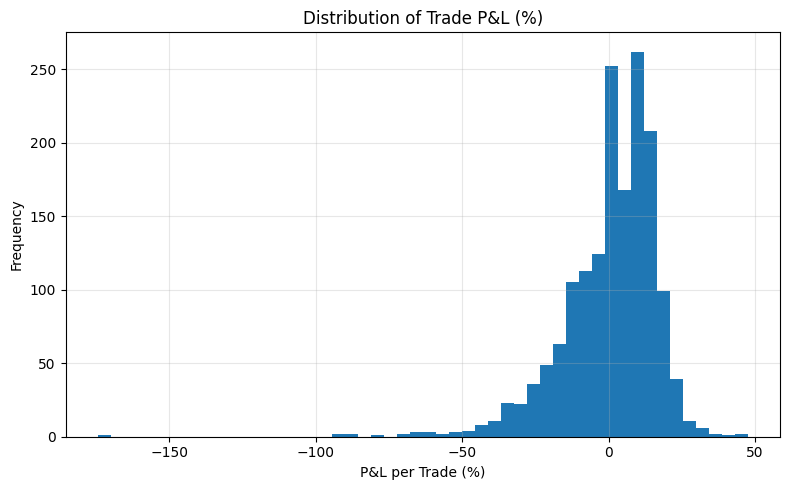

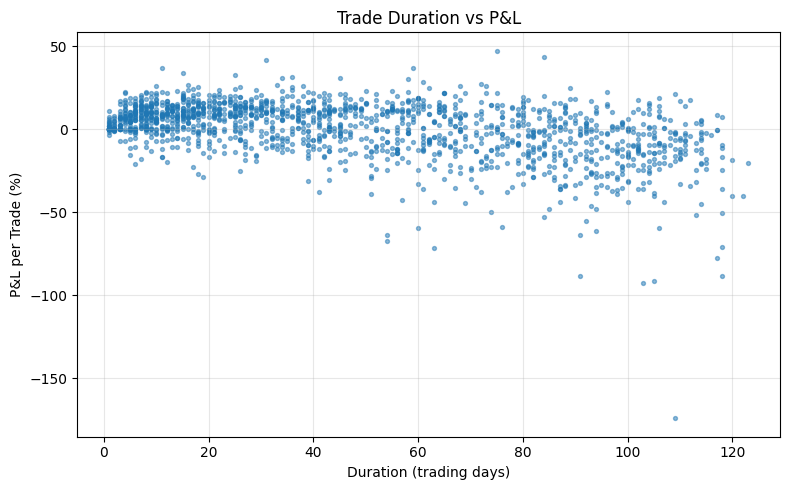

/var/folders/cm/69k42yy95z5gwss1vrkqcdgm0000gn/T/ipykernel_4227/3152657978.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily_port_ret.resample('M').apply(lambda x: (1+x).prod()-1)


               Mean %  Std %  Sharpe  Min %  Max %    N
Monthly Stats    0.09    3.2     0.1 -11.57   7.99  270
Mean daily return t-test: t=0.47, p=0.6359


In [8]:
# 1) Save Table 4.2 for the thesis
import matplotlib.pyplot as plt

table_4_2.round(2).to_excel("Table_4_2_GGR_Performance.xlsx")

# 2) Cumulative return figure (Figure 4.1)
import matplotlib.pyplot as plt
cum = (1 + daily_port_ret).cumprod()
plt.figure(figsize=(10,6))
plt.plot(cum, linewidth=2, label="GGR Strategy")
plt.title("Cumulative Portfolio Return (GGR Method)")
plt.xlabel("Date"); plt.ylabel("Portfolio Value (normalized to 1.0)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# 3) Rolling drawdown (supporting figure)
import numpy as np
roll_max = np.maximum.accumulate(cum.values)
dd = cum.values/roll_max - 1
plt.figure(figsize=(10,2.8))
plt.plot(cum.index, dd, linewidth=1.2)
plt.title("Rolling Drawdown"); plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 4) Histogram of trade P&L (supporting)
if not trade_log_all.empty:
    plt.figure(figsize=(8,5))
    plt.hist(trade_log_all["pnl"]*100, bins=50)
    plt.title("Distribution of Trade P&L (%)")
    plt.xlabel("P&L per Trade (%)"); plt.ylabel("Frequency")
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 5) Duration vs P&L (supporting)
    plt.figure(figsize=(8,5))
    plt.scatter(trade_log_all["duration_bars"], trade_log_all["pnl"]*100, s=8, alpha=0.5)
    plt.title("Trade Duration vs P&L"); plt.xlabel("Duration (trading days)")
    plt.ylabel("P&L per Trade (%)"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 6) Monthly returns table (optional but great for thesis)
import pandas as pd
monthly = daily_port_ret.resample('M').apply(lambda x: (1+x).prod()-1)
summary = pd.DataFrame({
    "Mean %": (monthly.mean()*100).round(2),
    "Std %":  (monthly.std()*100).round(2),
    "Sharpe": (monthly.mean()/monthly.std()*np.sqrt(12)).round(2),
    "Min %":  (monthly.min()*100).round(2),
    "Max %":  (monthly.max()*100).round(2),
    "N":      len(monthly)
}, index=["Monthly Stats"])
print(summary)
summary.to_excel("Appendix_Monthly_Returns_GGR.xlsx")

# 7) t-test for mean daily return (significance)
from scipy import stats
tstat, pval = stats.ttest_1samp(daily_port_ret.dropna(), 0.0)
print(f"Mean daily return t-test: t={tstat:.2f}, p={pval:.4f}")


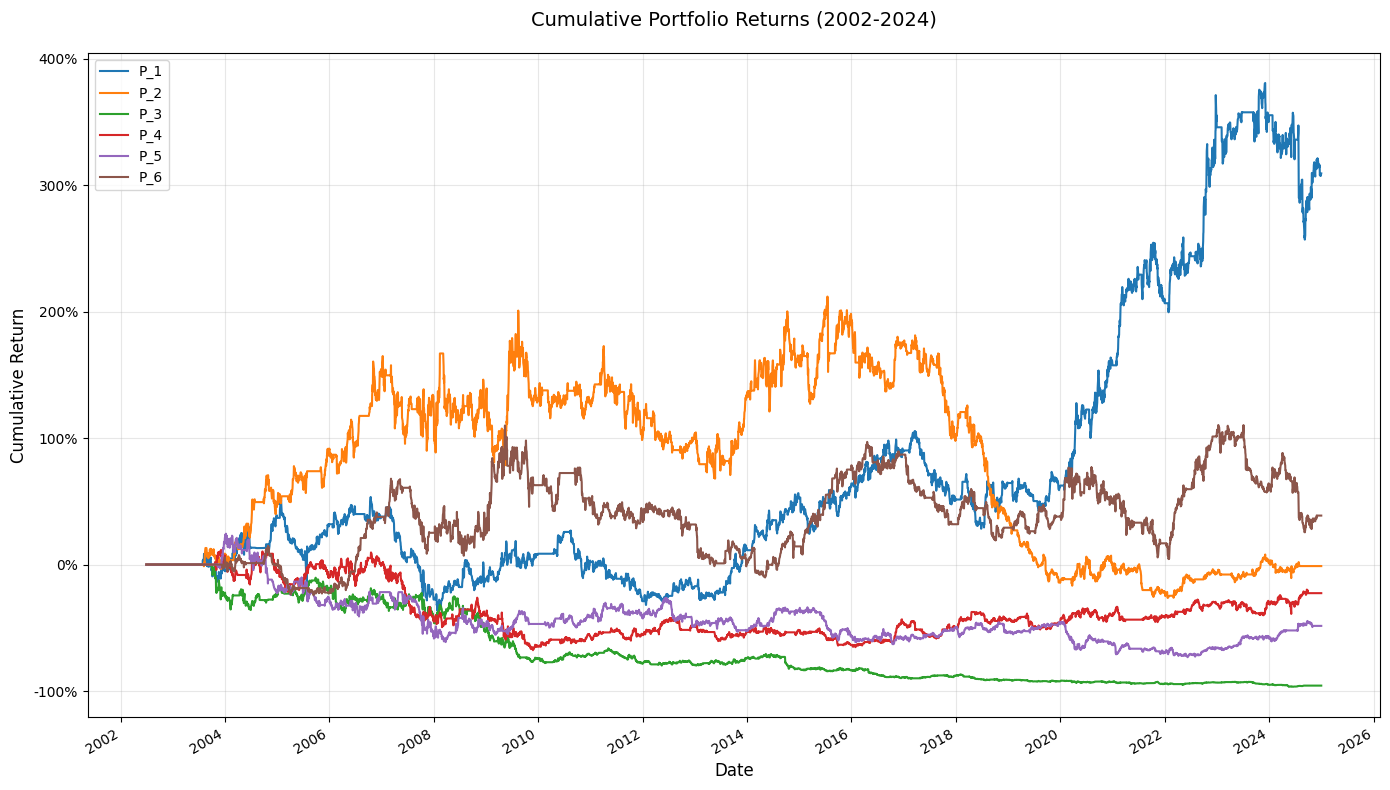

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(14, 8))

# Plot cumulative returns for all portfolios
for col in strat_returns_fi_w1d.columns:
    cumulative = (1 + strat_returns_fi_w1d[col]).cumprod() - 1
    plt.plot(cumulative, label=col, linewidth=1.5)

# Formatting
plt.title('Cumulative Portfolio Returns (2002-2024)', pad=20, fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)

# Y-axis as percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}')) 

# X-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Legend and grid
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.savefig("img/Portfolio_compo_triplet.jpg")
plt.show()


In [9]:
# ===========================================
# Appendix A1 — Hypothesis 1 Statistical Test
# ===========================================

import numpy as np
import pandas as pd
from scipy import stats

# daily_port_ret should be your Series of daily strategy returns (decimal form)
r = daily_port_ret.dropna().astype(float)

# ---- Descriptive diagnostics ----
mean_daily = r.mean()
std_daily  = r.std(ddof=1)
n_obs      = len(r)

ann_return = (1 + mean_daily)**252 - 1
ann_vol    = std_daily * np.sqrt(252)

print(f"Mean daily return: {mean_daily:.6f}")
print(f"Annualized return: {ann_return*100:.2f}%")
print(f"Annualized volatility: {ann_vol*100:.2f}%")
print(f"Sample size: {n_obs}")

# ---- One-sample t-test for H₀: μ = 0 ----
t_stat, p_value = stats.ttest_1samp(r, 0.0)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

# ---- Interpretation threshold ----
alpha = 0.05
if p_value < alpha:
    print("Result: Reject H₀ — Mean return is statistically greater than zero.")
else:
    print("Result: Fail to reject H₀ — Mean return not significantly different from zero.")


Mean daily return: 0.000053
Annualized return: 1.33%
Annualized volatility: 13.14%
Sample size: 5554
t-statistic: 0.473
p-value: 0.6359
Result: Fail to reject H₀ — Mean return not significantly different from zero.


In [ ]:
df_his = pd.read_csv("/Users/vikrambahadur/Downloads/Nifty50HistoricalData.csv")

In [ ]:
df_his.tail()

In [ ]:
df_his1 = pd.read_csv("data/Nifty50_Index.csv")
df_his1.head()

In [ ]:
df_his1 = pd.read_csv("data/Nifty50_Index.csv")
df_his1['Date'] = pd.to_datetime(df_his1['Date'])  # Convert string to datetime
df_his1.set_index('Date', inplace=True) 
merged_df = rt_df.join(df_his1, how='inner')  # Keeps only matching dates

In [ ]:
merged_df.head()